In [230]:
import gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque

In [231]:
# Set seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [232]:
# Create environment
env = gym.make("CartPole-v1")
env.reset(seed=seed)

(array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32),
 {})

# Q1. Deep Q-Network (DQN)

In [233]:
class DQNNet(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNNet, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [234]:
from collections import deque
import random

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

In [235]:
def train_dqn(env, episodes=1500, gamma=0.99, lr=1e-3, batch_size=128, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    policy_net = DQNNet(state_size, action_size)
    target_net = DQNNet(state_size, action_size)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    memory = ReplayBuffer()

    epsilon = epsilon_start
    rewards = []
    moving_avg = []

    for ep in range(episodes):
        state, _ = env.reset()
        state = np.array(state)
        total_reward = 0
        done = False

        while not done:
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    action = policy_net(torch.FloatTensor(state)).argmax().item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            memory.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if len(memory) > batch_size:
                states, actions, rewards_b, next_states, dones = memory.sample(batch_size)

                states = torch.FloatTensor(states)
                actions = torch.LongTensor(actions)
                rewards_b = torch.FloatTensor(rewards_b)
                next_states = torch.FloatTensor(next_states)
                dones = torch.FloatTensor(dones)

                q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()
                next_q_values = target_net(next_states).max(1)[0]
                expected_q = rewards_b + gamma * next_q_values * (1 - dones)

                loss = nn.MSELoss()(q_values, expected_q.detach())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        rewards.append(total_reward)
        moving_avg.append(np.mean(rewards[-50:]))

        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        if ep % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if ep % 50 == 0:
            print(f"Episode {ep}, Reward: {total_reward}, Moving Avg: {moving_avg[-1]:.2f}")

    # ✅ Save the trained DQN model here
    torch.save(policy_net.state_dict(), "dqn.pt")

    return rewards, moving_avg


C:\Users\Aryan Aarav\AppData\Roaming\Python\Python312\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0, Reward: 9.0, Moving Avg: 9.00
Episode 50, Reward: 9.0, Moving Avg: 23.64
Episode 100, Reward: 77.0, Moving Avg: 40.36
Episode 150, Reward: 79.0, Moving Avg: 71.94
Episode 200, Reward: 93.0, Moving Avg: 69.42
Episode 250, Reward: 51.0, Moving Avg: 115.16
Episode 300, Reward: 102.0, Moving Avg: 84.56
Episode 350, Reward: 104.0, Moving Avg: 84.60
Episode 400, Reward: 116.0, Moving Avg: 90.62
Episode 450, Reward: 110.0, Moving Avg: 95.88


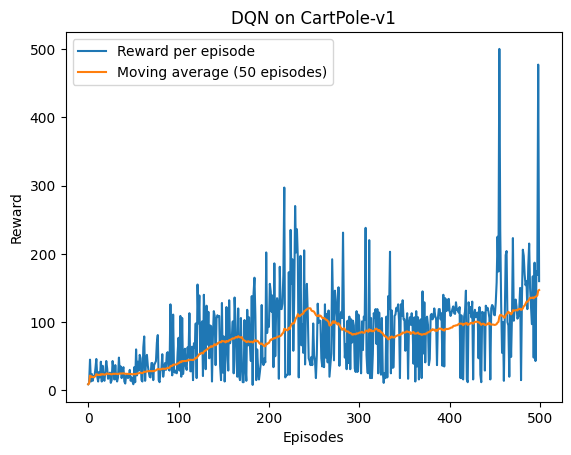

In [236]:
# Run DQN
rewards_dqn, moving_dqn = train_dqn(env, episodes=500)

plt.plot(rewards_dqn, label="Reward per episode")
plt.plot(moving_dqn, label="Moving average (50 episodes)")
plt.title("DQN on CartPole-v1")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.show()

# Q2. Policy Gradient (REINFORCE)

In [237]:
class PolicyNet(nn.Module):
    def __init__(self, state_size, action_size):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.softmax(self.fc2(x), dim=-1)


In [238]:
# Training loop for REINFORCE
def train_reinforce(env, episodes=1000, gamma=0.99, lr=1e-3):
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    policy_net = PolicyNet(state_size, action_size)
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)

    rewards = []
    moving_avg = []

    for ep in range(episodes):
        log_probs = []
        rewards_ep = []
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            state_tensor = torch.FloatTensor(state)
            action_probs = policy_net(state_tensor)
            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample()

            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated
            log_probs.append(action_dist.log_prob(action))
            rewards_ep.append(reward)
            state = next_state
            total_reward += reward

        returns = []
        G = 0
        for r in reversed(rewards_ep):
            G = r + gamma * G
            returns.insert(0, G)
        returns = torch.FloatTensor(returns)

        loss = 0
        for log_prob, Gt in zip(log_probs, returns):
            loss += -log_prob * Gt

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        rewards.append(total_reward)
        moving_avg.append(np.mean(rewards[-50:]))

        if ep % 50 == 0:
            print(f"Episode {ep}, Reward: {total_reward}, Moving Avg: {moving_avg[-1]:.2f}")

    # ✅ Save the trained REINFORCE model here
    torch.save(policy_net.state_dict(), "reinforce.pt")

    return rewards, moving_avg


Episode 0, Reward: 28.0, Moving Avg: 28.00
Episode 50, Reward: 29.0, Moving Avg: 29.68
Episode 100, Reward: 67.0, Moving Avg: 41.08
Episode 150, Reward: 66.0, Moving Avg: 47.26
Episode 200, Reward: 104.0, Moving Avg: 68.30
Episode 250, Reward: 67.0, Moving Avg: 113.74
Episode 300, Reward: 264.0, Moving Avg: 164.38
Episode 350, Reward: 234.0, Moving Avg: 189.46
Episode 400, Reward: 31.0, Moving Avg: 245.40
Episode 450, Reward: 434.0, Moving Avg: 354.66


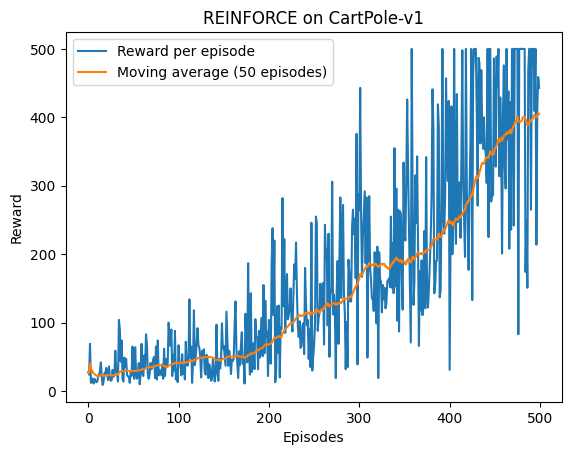

In [239]:
rewards_pg, moving_pg = train_reinforce(env, episodes=500)

plt.plot(rewards_pg, label="Reward per episode")
plt.plot(moving_pg, label="Moving average (50 episodes)")
plt.title("REINFORCE on CartPole-v1")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.show()

# Q3. Actor-Critic (A2C)

In [240]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.softmax(self.fc2(x), dim=-1)

class Critic(nn.Module):
    def __init__(self, state_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [241]:
# Training loop for A2C
def train_a2c(env, episodes=1000, gamma=0.99, lr=1e-3):
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    actor = Actor(state_size, action_size)
    critic = Critic(state_size)

    optimizerA = optim.Adam(actor.parameters(), lr=lr)
    optimizerC = optim.Adam(critic.parameters(), lr=lr)

    rewards = []
    moving_avg = []

    for ep in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            state_tensor = torch.FloatTensor(state)
            action_probs = actor(state_tensor)
            dist = torch.distributions.Categorical(action_probs)
            action = dist.sample()

            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated

            # Critic update
            value = critic(state_tensor)
            next_value = critic(torch.FloatTensor(next_state))
            td_target = reward + gamma * next_value * (1 - int(done))
            td_error = td_target - value

            critic_loss = td_error.pow(2)
            optimizerC.zero_grad()
            critic_loss.backward()
            optimizerC.step()

            # Actor update
            actor_loss = -dist.log_prob(action) * td_error.detach()
            optimizerA.zero_grad()
            actor_loss.backward()
            optimizerA.step()

            state = next_state
            total_reward += reward

        rewards.append(total_reward)
        moving_avg.append(np.mean(rewards[-50:]))

        if ep % 50 == 0:
            print(f"Episode {ep}, Reward: {total_reward}, Moving Avg: {moving_avg[-1]:.2f}")

    # ✅ Save the trained A2C models here
    torch.save(actor.state_dict(), "a2c_actor.pt")
    torch.save(critic.state_dict(), "a2c_critic.pt")

    return rewards, moving_avg


Episode 0, Reward: 21.0, Moving Avg: 21.00
Episode 50, Reward: 25.0, Moving Avg: 28.36
Episode 100, Reward: 104.0, Moving Avg: 65.26
Episode 150, Reward: 116.0, Moving Avg: 82.02
Episode 200, Reward: 81.0, Moving Avg: 214.92
Episode 250, Reward: 253.0, Moving Avg: 103.40
Episode 300, Reward: 245.0, Moving Avg: 132.16
Episode 350, Reward: 66.0, Moving Avg: 109.88
Episode 400, Reward: 36.0, Moving Avg: 111.94
Episode 450, Reward: 213.0, Moving Avg: 82.88


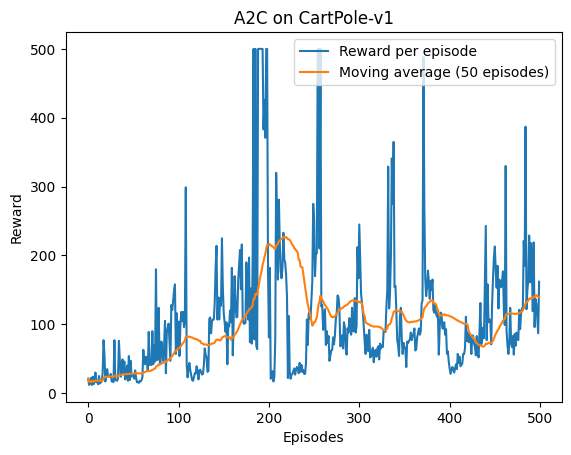

In [242]:
rewards_a2c, moving_a2c = train_a2c(env, episodes=500)
plt.plot(rewards_a2c, label="Reward per episode")
plt.plot(moving_a2c, label="Moving average (50 episodes)")
plt.title("A2C on CartPole-v1")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.show()

# Q4. Analysis and Comparison

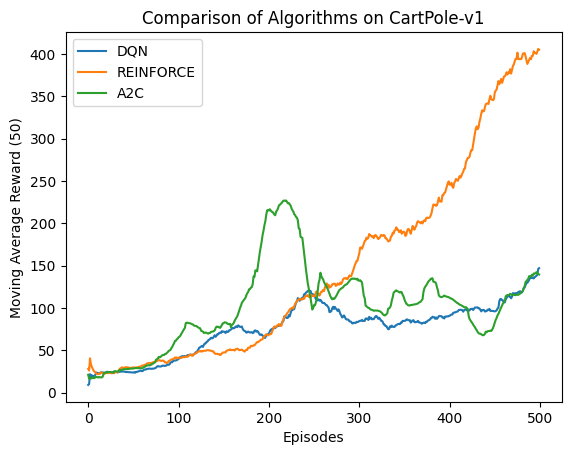

In [243]:
plt.plot(moving_dqn, label="DQN")
plt.plot(moving_pg, label="REINFORCE")
plt.plot(moving_a2c, label="A2C")
plt.title("Comparison of Algorithms on CartPole-v1")
plt.xlabel("Episodes")
plt.ylabel("Moving Average Reward (50)")
plt.legend()
plt.show()


In [244]:
import pandas as pd

hyperparams = {
    "Algorithm": ["DQN", "REINFORCE", "A2C"],
    "Learning Rate": [1e-3, 1e-3, 1e-3],
    "Gamma": [0.99, 0.99, 0.99],
    "Episodes": [1000, 1000, 1000],
    "Hidden Layers": ["64-64", "128", "128"]
}
df_hyper = pd.DataFrame(hyperparams)
print("Hyperparameters Used:")
print(df_hyper)

Hyperparameters Used:
   Algorithm  Learning Rate  Gamma  Episodes Hidden Layers
0        DQN          0.001   0.99      1000         64-64
1  REINFORCE          0.001   0.99      1000           128
2        A2C          0.001   0.99      1000           128


In [245]:
def get_final_results(name, rewards, moving):
    avg_last100 = np.mean(rewards[-100:])
    convergence_ep = np.argmax(np.array(moving) >= 195) if np.any(np.array(moving) >= 195) else "Not Converged"
    return [name, avg_last100, convergence_ep]

In [246]:
results = []
results.append(get_final_results("DQN", rewards_dqn, moving_dqn))
results.append(get_final_results("REINFORCE", rewards_pg, moving_pg))
results.append(get_final_results("A2C", rewards_a2c, moving_a2c))

In [247]:
df_results = pd.DataFrame(results, columns=["Algorithm", "AvgRewardLast100", "ConvergenceEpisode"])
print("\nFinal Results:")
print(df_results)


Final Results:
   Algorithm  AvgRewardLast100 ConvergenceEpisode
0        DQN            121.47      Not Converged
1  REINFORCE            375.82                341
2        A2C            109.39                195


In [248]:
df_results.to_csv("D:\Projects\OpenAIgym/results.csv", index=False)

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Aryan Aarav\AppData\Local\Temp\ipykernel_22596\1883307200.py:1: SyntaxWarning: invalid escape sequence '\P'
  df_results.to_csv("D:\Projects\OpenAIgym/results.csv", index=False)
